# ChatGPT usage in PubMed abstracts via excess vocabulary usage

In [1]:
%matplotlib notebook

import numpy as np
import pylab as plt
import pandas as pd
import pickle

plt.style.use('mpl_style.txt')

In [2]:
# results_folder = '../results/'
results_folder = '/home/dmitry/Downloads/'

words, years, counts, totals = pickle.load(open(results_folder + 'yearly-counts.pkl', 'rb'))

freqs = (counts + 1) / (totals + 1)

print('The shape of the yearly count matrix:', counts.shape)

The shape of the yearly count matrix: (4179571, 15)


In [3]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'
assert(len(alphabet) == 26)

allowedWords =  np.array([np.all([s in alphabet for s in w]) for w in words])
allowedWords &= np.array([len(w) >= 4 for w in words])

print('The number of 4+ letter words:', np.sum(allowedWords))

The number of 4+ letter words: 2417354


In [46]:
# word = 'traditional'

# print(counts[words == word].astype(int))
# print((freqs[words == word] * 1_000_000).astype(int))

# plt.figure(figsize=(3, 2))
# plt.plot(years, freqs[words==word].ravel(), '.-')

<IPython.core.display.Javascript object>


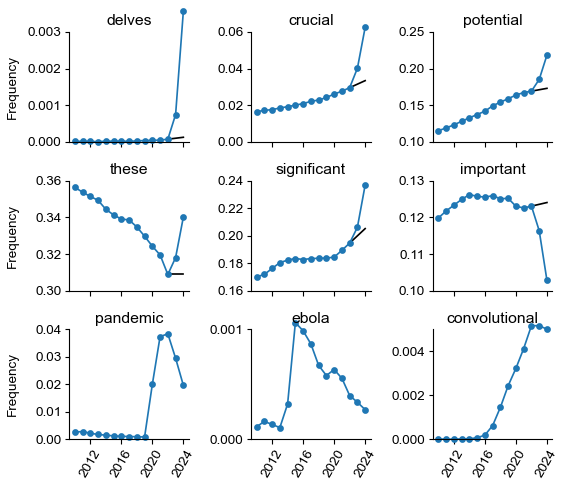

In [54]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(3.5, 3), layout='constrained')

for num, word in enumerate([
    'delves', 'crucial', 'potential', 'these', 'significant', 
    'important', 'pandemic', 'ebola', 'convolutional'
]):
    freq = freqs[words == word].ravel()
    axs.flat[num].plot(years, freq, '.-', clip_on=False)
    axs.flat[num].set_title(word)
    if num < 6:
        axs.flat[num].set_xticks([2012, 2016, 2020, 2024])
        axs.flat[num].set_xticklabels([])
    else:
        axs.flat[num].set_xticks([2012, 2016, 2020, 2024])
        axs.flat[num].set_xticklabels([2012, 2016, 2020, 2024], rotation=60)
    if num in [0, 3, 6]:
        axs.flat[num].set_ylabel('Frequency')
    if num < 6:
        proj = freq[-3] + np.maximum(0, (freq[-3] - freq[-4])) * 2
        axs.flat[num].plot([2022, 2024], [freq[-3], proj], 'k-', zorder=0)
        
    axs.flat[num].spines[['right', 'top']].set_visible(False)
    
fig.align_ylabels()

axs.flat[0].set_ylim([0, 0.003])
axs.flat[1].set_ylim([0, 0.06])
axs.flat[2].set_ylim([0.1, 0.25])
axs.flat[3].set_ylim([0.30, 0.36])
axs.flat[4].set_ylim([0.16, 0.24])
axs.flat[5].set_ylim([0.1, 0.13])
axs.flat[6].set_ylim([0, 0.04])
axs.flat[7].set_ylim([0, 0.001])
axs.flat[7].set_yticks([0, 0.001])
axs.flat[8].set_ylim([0, 0.005])

plt.savefig('../figures/examples.png', dpi=300)
plt.savefig('../figures/examples.pdf')

## Excess words in each year

In [5]:
def compute_excess(targetYear, cutoff=1e-4):
    subsetWords = allowedWords & (
        freqs[:, years == targetYear].ravel() >= cutoff
    ) & (
        freqs[:, years == targetYear - 1].ravel() >= cutoff
    )

    projection = freqs[subsetWords, years == targetYear - 2] + np.maximum(
        (
            freqs[subsetWords, years == targetYear - 2] - 
            freqs[subsetWords, years == targetYear - 3]
        ) * 2,
        0
    )
    
    ratios = freqs[subsetWords, years == targetYear] / projection
    diffs  = freqs[subsetWords, years == targetYear] - projection
    current_freqs = freqs[subsetWords][:, years == targetYear].ravel()
    
    return subsetWords, ratios, diffs, current_freqs

Analyzed words: 26121, increased frequency: 9993


<IPython.core.display.Javascript object>


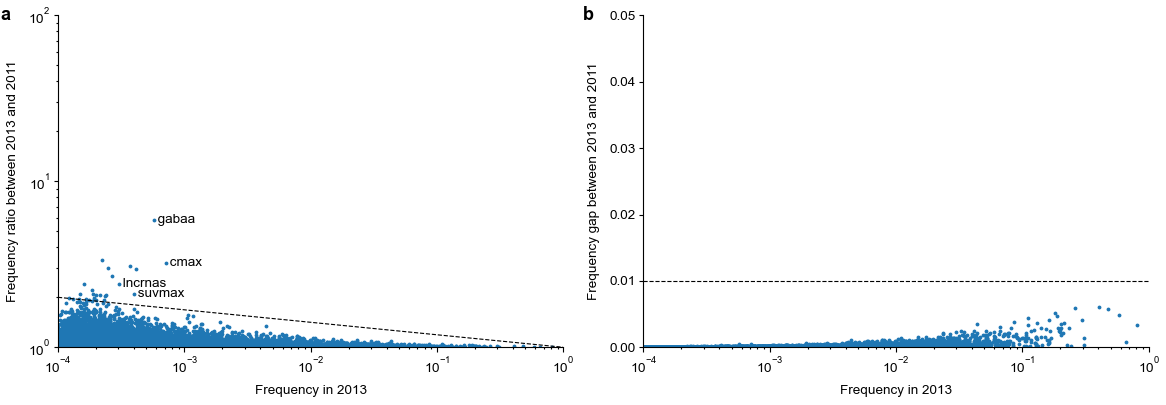

Analyzed words: 26271, increased frequency: 10001


<IPython.core.display.Javascript object>


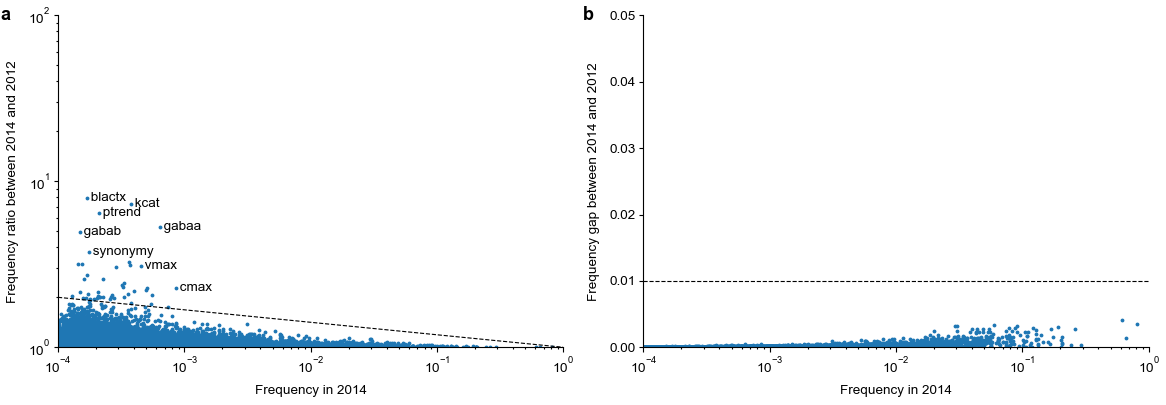

Analyzed words: 26292, increased frequency: 8812


<IPython.core.display.Javascript object>


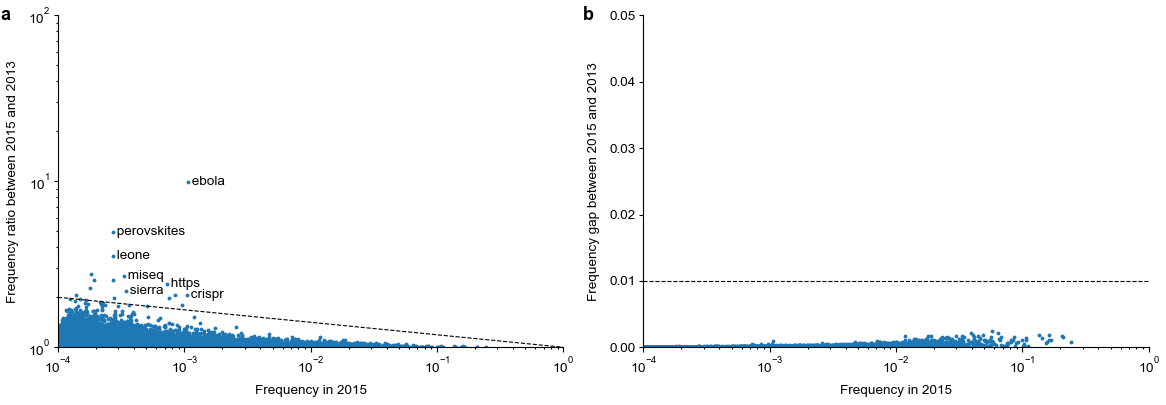

Analyzed words: 26363, increased frequency: 9465


<IPython.core.display.Javascript object>


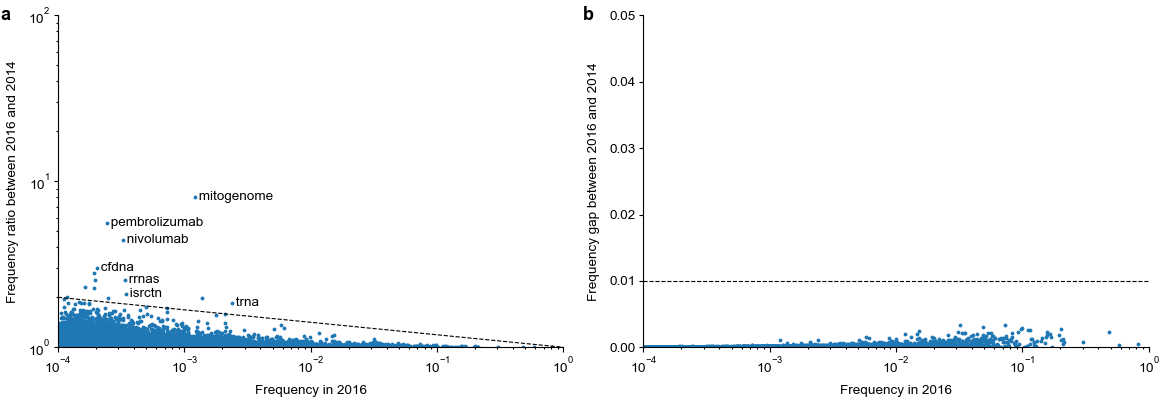

Analyzed words: 26538, increased frequency: 10566


<IPython.core.display.Javascript object>


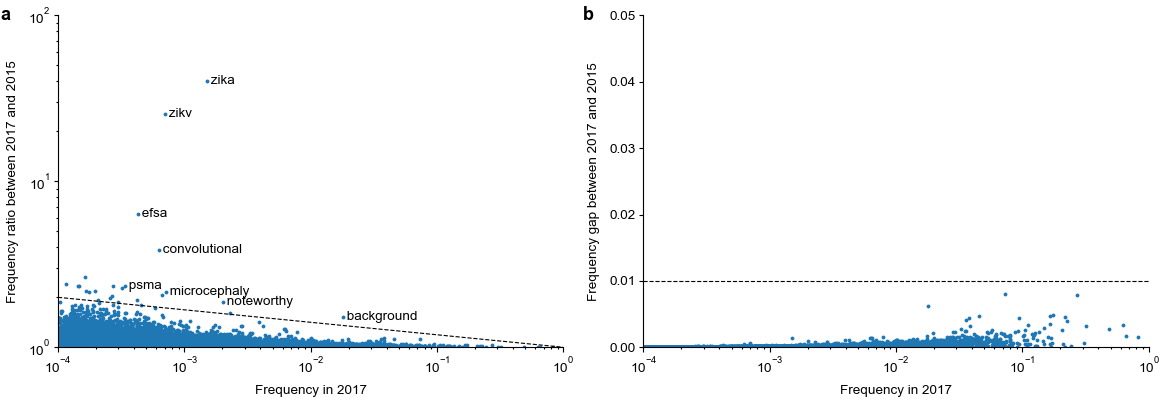

Analyzed words: 26571, increased frequency: 10095


<IPython.core.display.Javascript object>


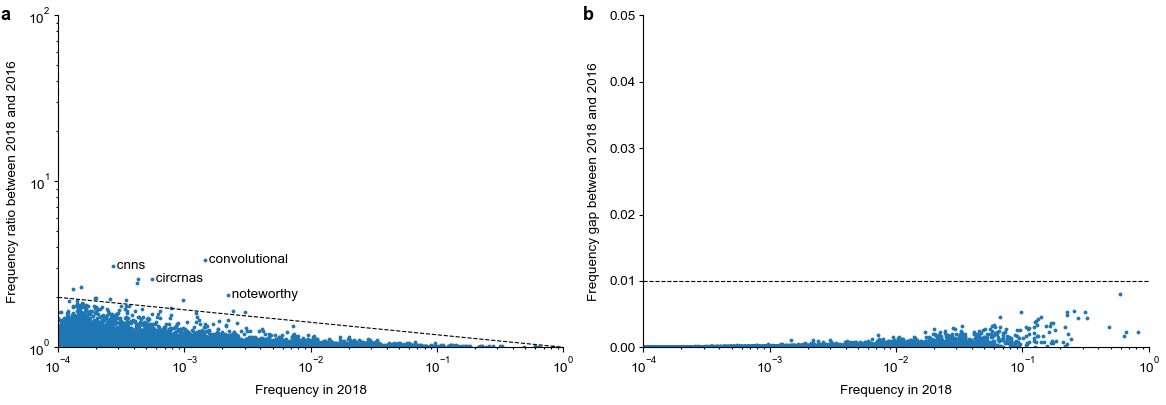

Analyzed words: 26656, increased frequency: 9422


<IPython.core.display.Javascript object>


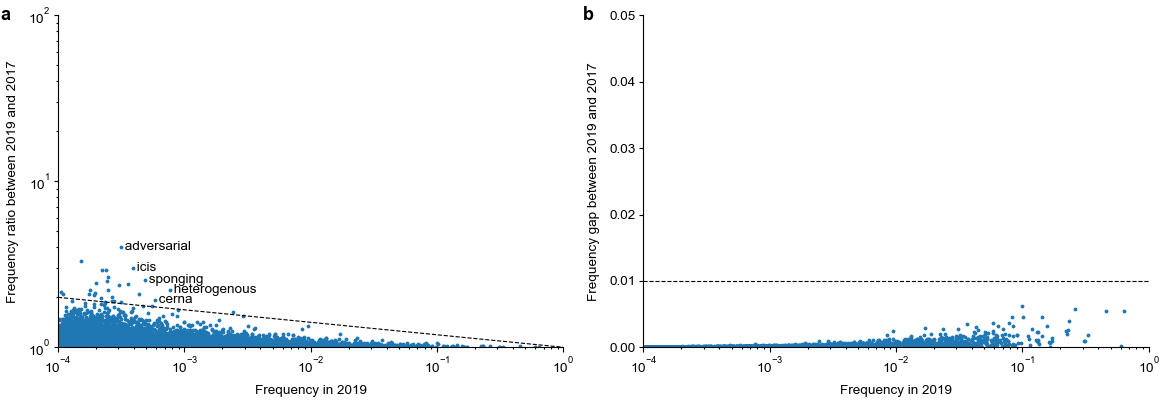

Analyzed words: 26655, increased frequency: 8764


<IPython.core.display.Javascript object>


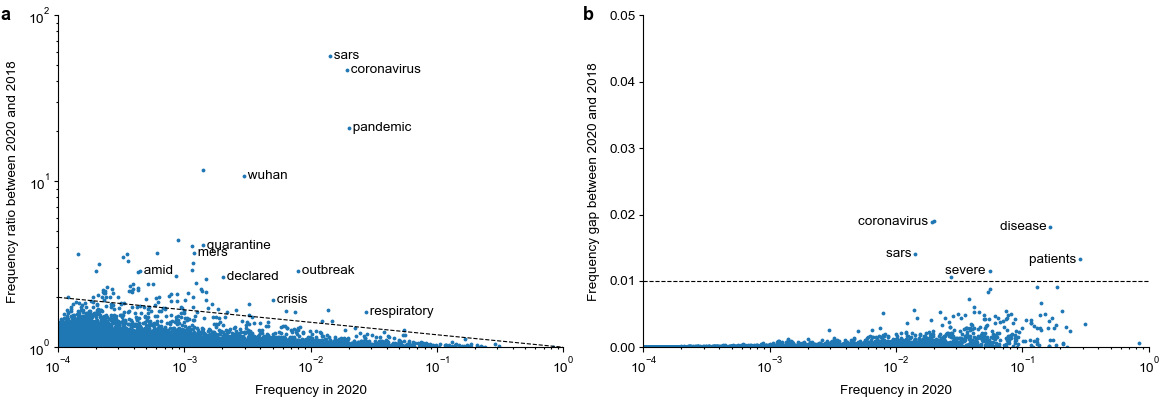

Analyzed words: 26625, increased frequency: 9099


<IPython.core.display.Javascript object>


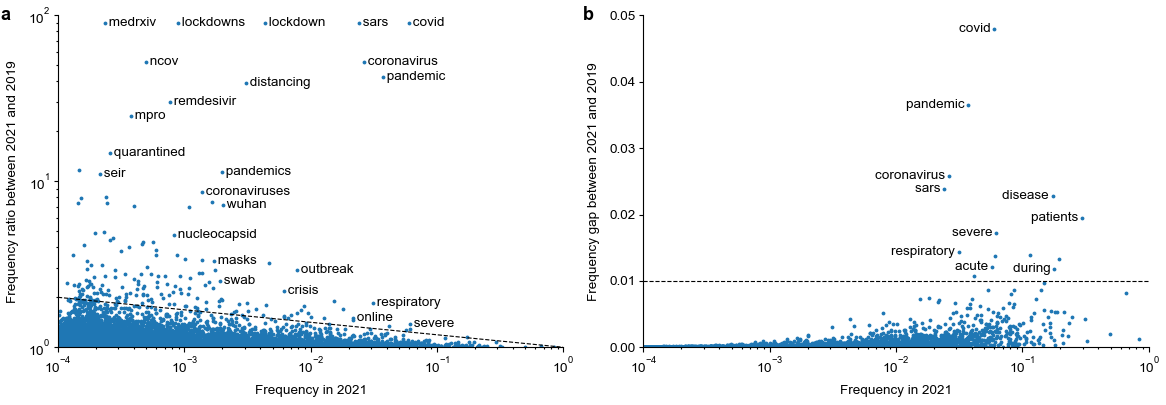

Analyzed words: 26663, increased frequency: 8831


<IPython.core.display.Javascript object>


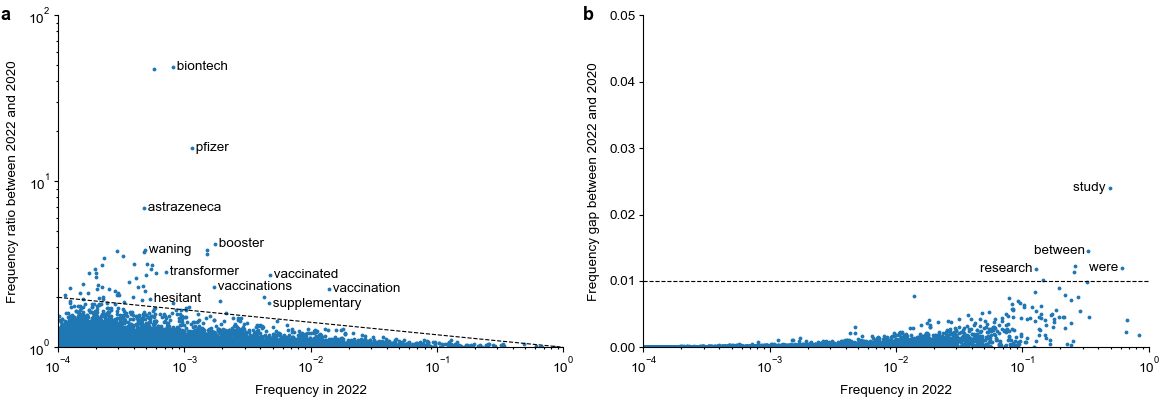

Analyzed words: 26730, increased frequency: 9919


<IPython.core.display.Javascript object>


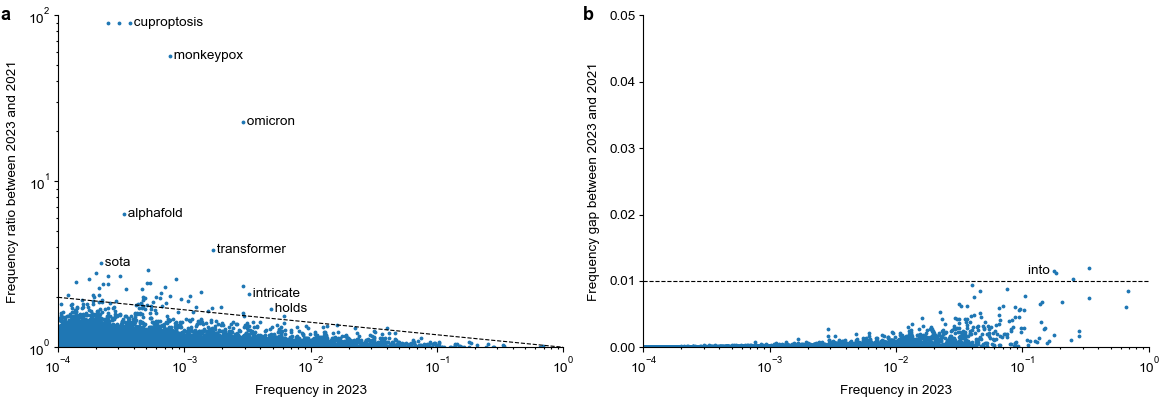

Analyzed words: 26646, increased frequency: 10589


<IPython.core.display.Javascript object>


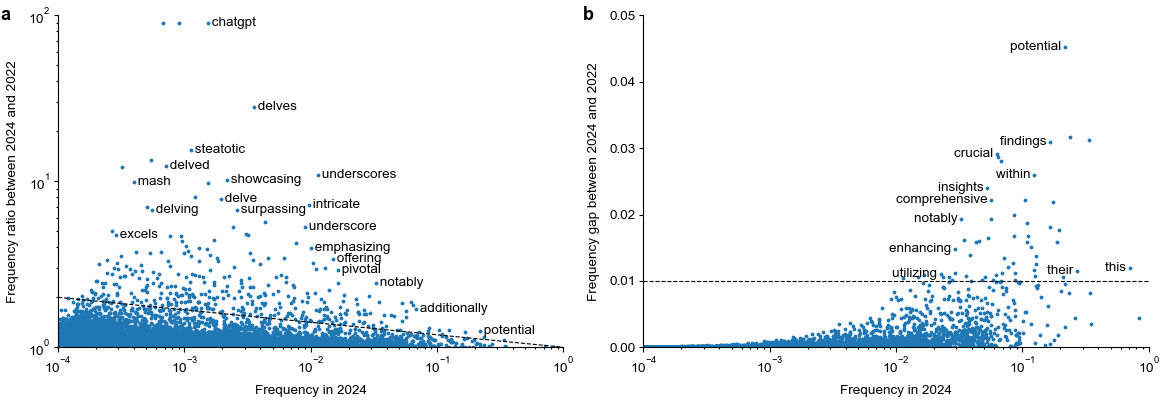

In [56]:
def yearplot(targetYear):
    subsetWords, ratios, diffs, x = compute_excess(targetYear)
    
    print(f'Analyzed words: {ratios.size}, increased frequency: {np.sum(ratios > 1)}')
    
    ratios[ratios > 90] = 90
    diffs[diffs > 0.048] = 0.048
    
    fig = plt.figure(figsize=(7.2, 2.5), layout='constrained')
    plt.subplot(121)
    plt.scatter(x[ratios > 1], ratios[ratios > 1], s=2, rasterized=True)
    plt.ylim([1, 100])
    plt.xlim([1e-4, 1])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(f'Frequency in {targetYear}')
    plt.ylabel(f'Frequency ratio between {targetYear} and {targetYear - 2}')
    plt.plot([1e-4, 1], [2, 1], 'k--', linewidth=.5)
    
    txts_a = []
    txts_points_a = []
    show_labels = np.log10(ratios) > np.log10(2.2) - (np.log10(x) + 4) * (np.log10(2) / 4)
    ind_show_labels = np.where(show_labels)[0]
#     reorder = np.argsort(x[ind_show_labels])[::-1]
#     ind_show_labels = ind_show_labels[reorder]
    for i in ind_show_labels:
        txt = plt.text(x[i], ratios[i], ' ' + words[subsetWords][i], fontsize=6, va='center')
#                       bbox = dict(facecolor='none', edgecolor='k', boxstyle='square,pad=0'))
        txts_a.append(txt)
        txt = plt.text(x[i], ratios[i], ' ', fontsize=6, va='center')
#                       bbox = dict(facecolor='none', edgecolor='r', boxstyle='square,pad=0'))
        txts_points_a.append(txt)
        
    plt.gca().spines[['right', 'top']].set_visible(False)

    plt.subplot(122)
    plt.scatter(x[diffs > 0], diffs[diffs > 0], s=2, rasterized=True)
    plt.gca().spines[['right', 'top']].set_visible(False)
    plt.xlim([1e-4, 1])
    plt.xscale('log')
    plt.ylim([0, 0.05])
    plt.plot([1e-4, 1], [0.01, 0.01], 'k--', linewidth=.5)
    plt.xlabel(f'Frequency in {targetYear}')
    plt.ylabel(f'Frequency gap between {targetYear} and {targetYear - 2}')
    
    fig.text(0, .95, 'a', fontsize=8, fontweight='bold')
    fig.text(.5, .95, 'b', fontsize=8, fontweight='bold')
    
    txts_b = []
    txts_points_b = []
    for i in np.where(diffs > 0.011)[0]:
        txt = plt.text(x[i], diffs[i], words[subsetWords][i] + ' ', fontsize=6, ha='right', va='center')
        txts_b.append(txt)
        txt = plt.text(x[i], diffs[i], ' ', fontsize=6, ha='right', va='center')
        txts_points_b.append(txt)
    
    fig.canvas.draw()

    def cleanup_labels(txts, txts_points, ha='left'):
        removed = np.zeros(len(txts), dtype=bool)
        bbox = txts_points[0].get_window_extent()
        space_width = bbox.x1 - bbox.x0
        for i in range(len(txts)):
            bbox = txts[i].get_window_extent()
            if ha == 'left':
                bbox.x0 += space_width
            else:
                bbox.x1 -= space_width
            for j in range(len(txts)):
                if j != i:
                    bbox_point = txts_points[j].get_window_extent()
                    bbox_point.y0 += (bbox_point.y1 - bbox_point.y0) / 3
                    bbox_point.y1 -= (bbox_point.y1 - bbox_point.y0) / 3
                    if bbox.overlaps(bbox_point):
                        removed[i] = True
                        txts[i].remove()
                        break

#         for txt in txts_points:
#             txt.remove()

#         for i in range(len(txts)):
#             if not removed[i]:
#                 for j in range(i):
#                     if not removed[j]:
#                         if txts[i].get_window_extent().overlaps(txts[j].get_window_extent()):
#                             removed[i] = True
#                             txts[i].remove()
#                             break   
        
    if len(txts_a) > 0:
        cleanup_labels(txts_a, txts_points_a)
    if len(txts_b) > 0:
        cleanup_labels(txts_b, txts_points_b, ha='right')


for targetYear in range(2013, 2025):
    yearplot(targetYear)
        
    plt.savefig(f'../figures/words{targetYear}.png', dpi=300)
    plt.savefig(f'../figures/words{targetYear}.pdf', dpi=300)

In [61]:
noteworthy_words = {
    2024: ['delves', 'showcasing', 'underscores', 'potential', 'findings', 'crucial'],
    2015: ['ebola'],
    2017: ['zika'],
    2021: ['coronavirus', 'lockdown', 'pandemic', 'covid']
}

for year in noteworthy_words:
    print('--- ' + str(year) + ' ---')
    
    subsetWords, ratios, diffs, _ = compute_excess(year)
    
    for word in noteworthy_words[year]:
        print(
            f'{word:15}: {ratios[words[subsetWords] == word][0]:5.2f},'
            f' {diffs[words[subsetWords] == word][0]:.3f}'
        )
    
    print('')

--- 2024 ---
delves         : 28.00, 0.003
showcasing     : 10.15, 0.002
underscores    : 10.88, 0.010
potential      :  1.26, 0.045
findings       :  1.23, 0.031
crucial        :  1.87, 0.029

--- 2015 ---
ebola          :  9.92, 0.001

--- 2017 ---
zika           : 40.39, 0.001

--- 2021 ---
coronavirus    : 52.71, 0.026
lockdown       : 1495.72, 0.004
pandemic       : 42.53, 0.037
covid          : 3912.07, 0.060



## Summary across years

In [6]:
targetYears = np.arange(2013, 2025)

excess_words_per_year = []

for num, targetYear in enumerate(targetYears):
    subsetWords, ratios, diffs, x = compute_excess(targetYear)
        
    ind = np.log10(ratios) > np.log10(2) - (np.log10(x) + 4) * (np.log10(2) / 4)
    ind |= diffs > 0.01
    
    excess_words = list(words[subsetWords][ind])
    
    excess_words_per_year.append(excess_words)
    
    print(f'{targetYear}: found {len(excess_words):3} excess words. ', end='')
    
    cutoff_ratio = 3
    cutoff_freq = 1e-3
    if np.max(ratios[x > cutoff_freq]) < cutoff_ratio:
        print('')
    else:
        top_word = words[subsetWords][x > cutoff_freq][np.argmax(ratios[x > cutoff_freq])]
        print(f' Top word: {top_word}')

2013: found  22 excess words. 
2014: found  46 excess words. 
2015: found  19 excess words.  Top word: ebola
2016: found  14 excess words.  Top word: mitogenome
2017: found  25 excess words.  Top word: zika
2018: found  16 excess words.  Top word: convolutional
2019: found  28 excess words. 
2020: found  90 excess words.  Top word: sars
2021: found 189 excess words.  Top word: covid
2022: found  68 excess words.  Top word: pfizer
2023: found  64 excess words.  Top word: omicron
2024: found 382 excess words.  Top word: chatgpt


In [7]:
all_excess_words = []
for exc in excess_words_per_year:
    all_excess_words += exc
    
all_excess_words = np.unique(all_excess_words)

print(f'Found {all_excess_words.size} unique excess words overall')

Found 829 unique excess words overall


In [8]:
annotations = pd.read_csv('../results/excess_words.csv')

word2type = dict(zip(annotations.word, annotations.type))
word2partofspeech = dict(zip(annotations.word, annotations.part_of_speech))

print('Words that need to be annotated:')
print(np.setdiff1d(all_excess_words, annotations.word.values))
print('')

print('Words that should be removed from the annotations table:')
print(np.setdiff1d(annotations.word.values, all_excess_words))

Words that need to be annotated:
[]

Words that should be removed from the annotations table:
[]


In [9]:
total = np.zeros_like(targetYears)
content = np.zeros_like(targetYears)
style = np.zeros_like(targetYears)
nouns = np.zeros_like(targetYears)
verbs = np.zeros_like(targetYears)
adjectives = np.zeros_like(targetYears)

for i, exc in enumerate(excess_words_per_year):
    total[i] = len(exc)
    content[i] = np.sum([word2type[w] == 'content' for w in exc])
    style[i] = np.sum([word2type[w] == 'style' for w in exc])
    nouns[i] = np.sum([word2partofspeech[w] == 'noun' for w in exc])
    verbs[i] = np.sum([word2partofspeech[w] == 'verb' for w in exc])
    adjectives[i] = np.sum([word2partofspeech[w] == 'adjective' for w in exc])

<IPython.core.display.Javascript object>


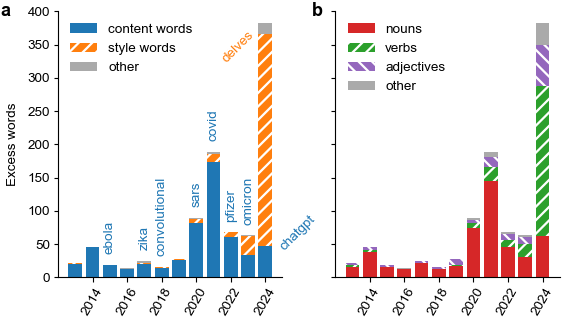

In [10]:
fig = plt.figure(figsize=(3.5, 2), layout='constrained')

plt.subplot(121)
plt.bar(targetYears, content, color='tab:blue', label='content words')
plt.bar(targetYears, style, bottom=content, color='tab:orange', label='style words', 
        hatch="////", edgecolor='w', linewidth=0)
plt.bar(targetYears, total - style - content, bottom=content + style, color='#aaaaaa', label='other')

top_words = {
    2015: 'ebola',
    2017: 'zika',
    2018: 'convolutional',
    2020: 'sars',
    2021: 'covid',
    2022: 'pfizer',
    2023: 'omicron',
}

for year in top_words:
    plt.text(year, total[targetYears == year] + 20, top_words[year], rotation=90, ha='center', color='tab:blue')
    
plt.text(2024.7, content[-1] + 20, 'chatgpt', va='center', color='tab:blue', rotation=45)
plt.text(2023.5, style[-1] + content[-1] - 20, 'delves', va='center', color='tab:orange', rotation=45, ha='right')

plt.ylim([0, 400])
plt.ylabel('Excess words')
plt.xticks([2014, 2016, 2018, 2020, 2022, 2024], rotation=60)
plt.legend()
plt.gca().spines[['right', 'top']].set_visible(False)
    
plt.subplot(122)

plt.bar(targetYears, nouns, color='tab:red', label='nouns')
plt.bar(targetYears, verbs, color='tab:green', label='verbs', bottom=nouns,
        hatch="////", edgecolor='w', linewidth=0)
plt.bar(targetYears, adjectives, color='tab:purple', label='adjectives', bottom=nouns + verbs,
        hatch="\\\\\\\\", edgecolor='w', linewidth=0)
plt.bar(targetYears, total - nouns - verbs - adjectives, color='#aaaaaa', label='other', 
        bottom = nouns + verbs + adjectives)

plt.ylim([0, 400])
plt.gca().set_yticklabels([])
plt.xticks([2014, 2016, 2018, 2020, 2022, 2024], rotation=60)
plt.legend()
plt.gca().spines[['right', 'top']].set_visible(False)

fig.text(0, .95, 'a', fontsize=8, fontweight='bold')
fig.text(.55, .95, 'b', fontsize=8, fontweight='bold')

plt.savefig('../figures/excess-per-year.png', dpi=300)
plt.savefig('../figures/excess-per-year.pdf')

In [171]:
exc = [w for w in excess_words_per_year[-1] if word2type[w] == 'style']

print(f"{len(exc)} excess style words in 2024")
print(f"{100 * np.mean([word2partofspeech[w] == 'verb' for w in exc]):.1f}% verbs")
print(f"{100 * np.mean([word2partofspeech[w] == 'adjective' for w in exc]):.1f}% adjectives")

319 excess style words in 2024
65.8% verbs
16.0% adjectives


## Excess gap based on rare style excess words

In [138]:
subsetWords, ratios, diffs, x = compute_excess(2024)

ind = np.log10(ratios) > np.log10(2) - (np.log10(x) + 4) * (np.log10(2) / 4)
ind |= diffs > 0.01

chatgpt_words =   np.array(
    [w         for i, w in enumerate(words[subsetWords][ind]) if word2type[w] == 'style']
)
chatgpt_words_f = np.array(
    [x[ind][i] for i, w in enumerate(words[subsetWords][ind]) if word2type[w] == 'style']
)

cutoffs = [0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]

for cutoff in cutoffs:
    print(f'Cutoff: {cutoff:6}, number of style words: {np.sum(chatgpt_words_f < cutoff)}')

Cutoff: 0.0002, number of style words: 6
Cutoff: 0.0005, number of style words: 46
Cutoff:  0.001, number of style words: 88
Cutoff:  0.002, number of style words: 142
Cutoff:  0.005, number of style words: 187
Cutoff:   0.01, number of style words: 222
Cutoff:   0.02, number of style words: 259
Cutoff:   0.05, number of style words: 285
Cutoff:    0.1, number of style words: 301
Cutoff:    0.2, number of style words: 314
Cutoff:    0.5, number of style words: 318


<IPython.core.display.Javascript object>


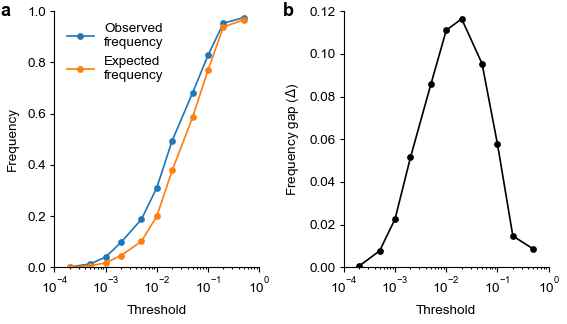

In [172]:
cutoff_counts = np.load('../results/yearly-counts-cutoff.npy')

cutoffs = [0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]

cutoff_freqs = (cutoff_counts + 1) / (totals + 1)

deltas = np.zeros(len(cutoffs))
ps = np.zeros(len(cutoffs))
qs = np.zeros(len(cutoffs))

for i, f in enumerate(cutoff_freqs):
    projection = f[-3] + np.maximum(0, f[-3] - f[-4]) * 2
    deltas[i] = f[-1] - projection
    ps[i] = f[-1]
    qs[i] = projection
    
fig = plt.figure(figsize=(3.5, 2), layout='constrained')
plt.subplot(121)
plt.plot(cutoffs, ps, '.-', label='Observed\nfrequency')
plt.plot(cutoffs, qs, '.-', label='Expected\nfrequency')
plt.legend()
plt.xscale('log')
plt.xlim([1e-4, 1])
plt.ylim([0, 1])
plt.ylabel('Frequency')
plt.xlabel('Threshold')

plt.subplot(122)
plt.plot(cutoffs, deltas, 'k.-', label='Frequency gap (Delta)')
plt.xscale('log')
plt.xlim([1e-4, 1])
plt.ylim([0, .12])
plt.ylabel(r'Frequency gap ($\Delta$)')
plt.xlabel('Threshold')

fig.text(0, .95, 'a', fontsize=8, fontweight='bold')
fig.text(.5, .95, 'b', fontsize=8, fontweight='bold')

plt.savefig('../figures/delta-curve.png', dpi=200)
plt.savefig('../figures/delta-curve.pdf')

## Subgroup analysis

In [173]:
df_subsets = pd.read_csv('../results/yearly-counts-subgroups.csv')

for i in range(len(df_subsets)):
    f = (df_subsets.values[i, 2:2+15] + 1) / (df_subsets.values[i, 2+30:2+45] + 1)
    projection = f[-3] + np.maximum(0, f[-3] - f[-4]) * 2
    delta_common = f[-1] - projection
    
    f = (df_subsets.values[i, 2+15:2+30] + 1) / (df_subsets.values[i, 2+30:2+45] + 1)
    projection = f[-3] + np.maximum(0, f[-3] - f[-4]) * 2
    delta_rare = f[-1] - projection
    
    if np.all(df_subsets.values[i, 2+30:2+45][-7:-1] >= 300):
        df_subsets.loc[i, 'delta_common'] = delta_common
        df_subsets.loc[i, 'delta_rare'] = delta_rare
        df_subsets.loc[i, 'delta'] = (delta_rare + delta_common) / 2
    else:
        df_subsets.loc[i, 'delta_common'] = np.nan
        df_subsets.loc[i, 'delta_rare'] = np.nan
        df_subsets.loc[i, 'delta'] = np.nan
        
df_subsets

,grouptype,group,2010_common,2011_common,2012_common,2013_common,2014_common,2015_common,2016_common,2017_common,...,2018_total,2019_total,2020_total,2021_total,2022_total,2023_total,2024_total,delta_common,delta_rare,delta
0,all,all,150261,164543,184049,200860,218600,232100,246485,259524,...,981969,1036781,1178035,1335034,1365878,1315337,772691,0.109554,0.111056,0.110305
1,class,surgery,2675,2814,3300,3561,3967,4213,4431,4630,...,24342,25804,29026,32310,35435,32559,21540,0.099189,0.095774,0.097482
2,class,psychiatry,1415,1566,1734,1866,2045,2109,2308,2300,...,7870,7704,8601,10732,10875,10906,6333,0.076996,0.088077,0.082537
3,class,microbiology,2496,2676,2862,2868,3217,3583,4007,4085,...,12529,13182,14262,15937,18218,15674,8115,0.066531,0.097935,0.082233
4,class,physics,2171,2473,3029,2700,2784,2959,2729,2631,...,9392,8639,9311,9384,8630,9200,5878,0.116145,0.113759,0.114952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,country/journals,South Korea & Basel,19,19,25,34,49,70,112,150,...,864,1342,2325,3397,3217,3054,1043,0.240504,0.275448,0.257976
232,country/journals,Taiwan & Frontiers,0,3,5,15,21,22,41,63,...,234,276,412,871,1109,500,141,NaN,NaN,NaN
233,country/journals,Taiwan & Basel,14,27,25,28,36,44,59,66,...,299,432,759,1349,1462,1101,380,NaN,NaN,NaN
234,country/journals,Iran & Frontiers,0,0,0,1,3,5,8,8,...,86,157,227,496,905,641,225,NaN,NaN,NaN


<IPython.core.display.Javascript object>


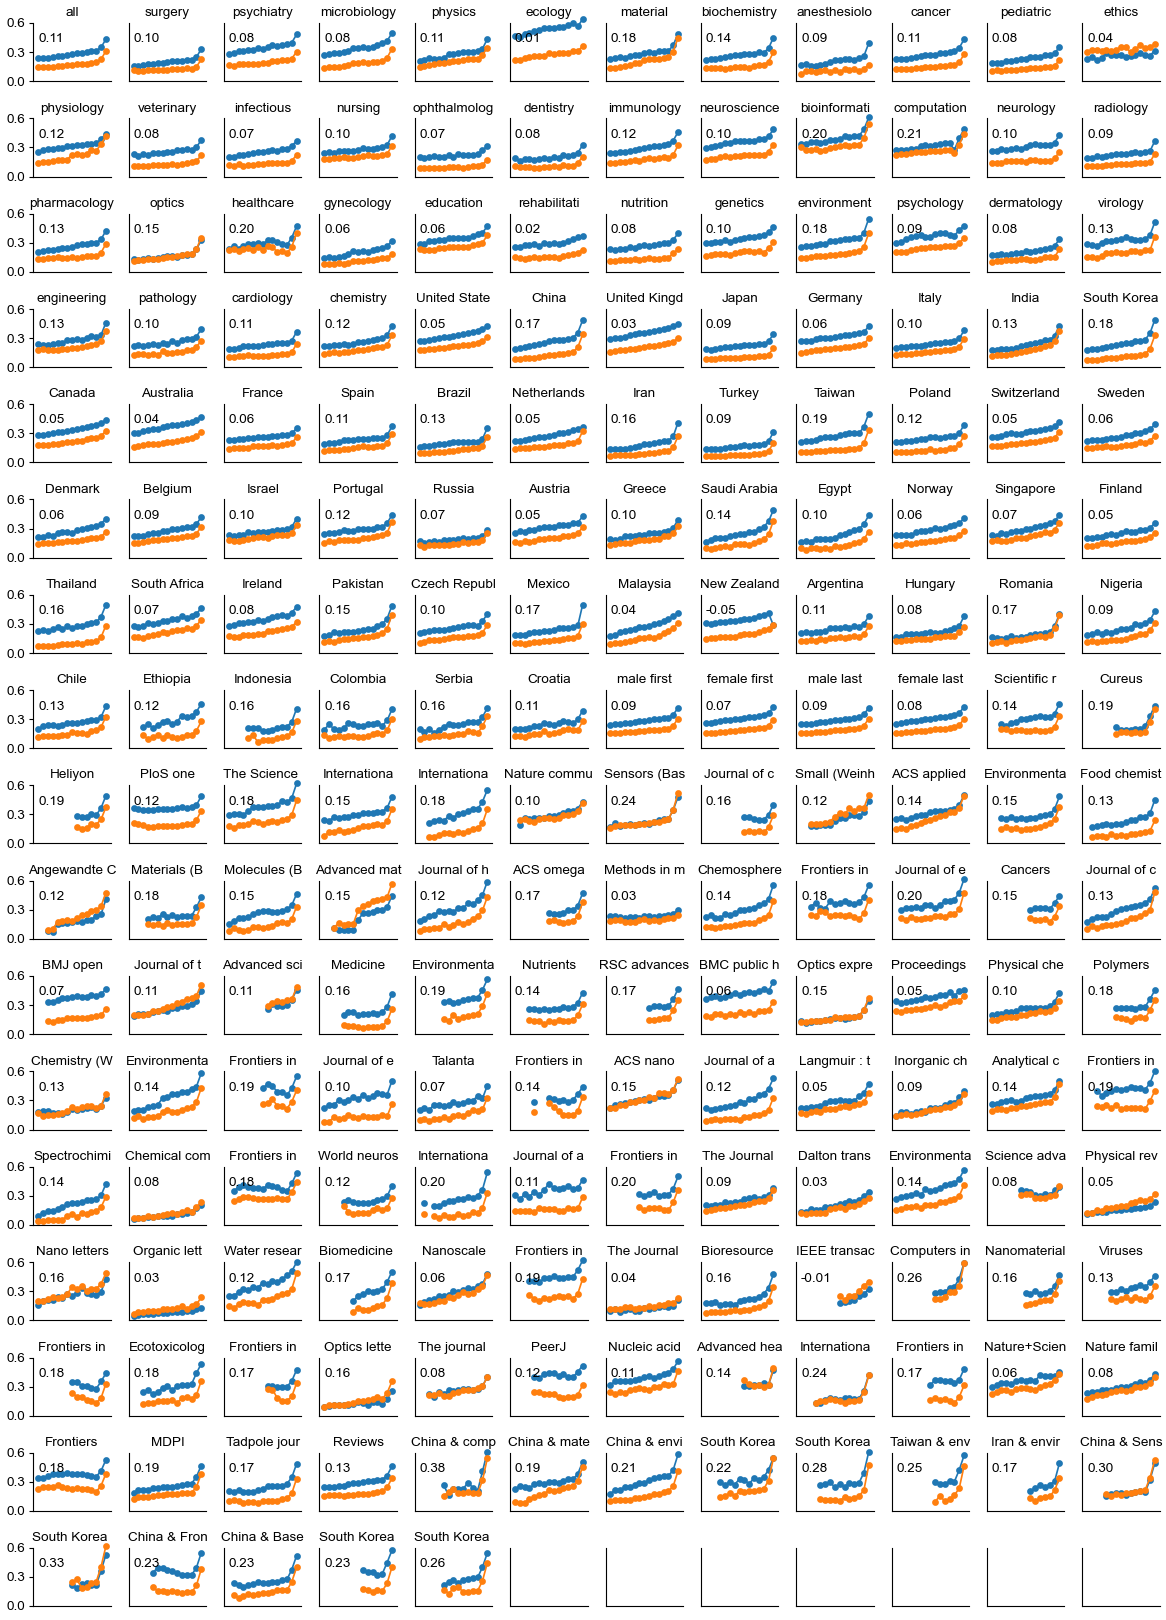

In [174]:
fig, axs = plt.subplots(nrows=17, ncols=12, figsize=(7.2, 10), layout='constrained')
num = 0

for i in range(len(df_subsets)):
    group = df_subsets.group.values[i]
    common = df_subsets.values[i, 2:2+15].ravel().astype(float)
    rare = df_subsets.values[i, 2+15:2+30].ravel().astype(float)
    total = df_subsets.values[i, 2+30:2+45].ravel().astype(float)
    
    total[:-1][total[:-1] < 300] = np.nan
    
    if np.all(~np.isnan(total[-7:-1])):
        axs.flat[num].plot(years, (common + 1) / (total + 1), '.-', clip_on=False)
        axs.flat[num].plot(years, (rare + 1) / (total + 1), '.-', clip_on=False)
        axs.flat[num].set_title(group[:12], fontsize=6)
        
        axs.flat[num].text(2010, .4, f'{df_subsets.delta.values[i]:.2f}')
        
        num += 1
        
    if num == axs.size:
        break
    
for i in range(axs.size):
    axs.flat[i].set_xticks([])
    if i % axs.shape[1]:
        axs.flat[i].set_yticks([])
    else:
        axs.flat[i].set_yticks([0, .3, .6])
    axs.flat[i].spines[['right', 'top']].set_visible(False)
    axs.flat[i].set_ylim([0, .6])
    axs.flat[i].set_xlim([2009, 2025])

<IPython.core.display.Javascript object>


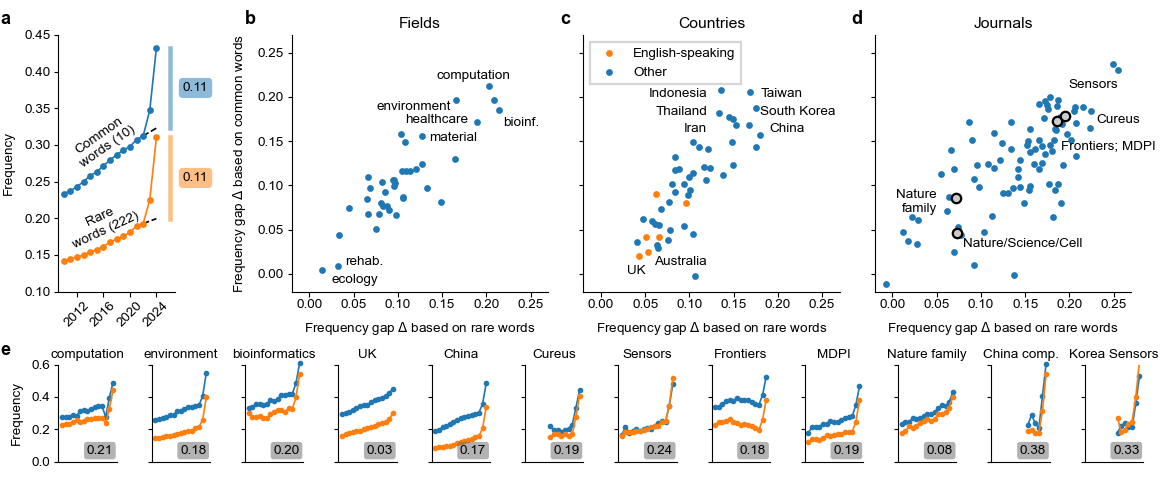

common: gap = 0.110
rare: gap = 0.111


/home/dmitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
/home/dmitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:214: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword


In [190]:
fig = plt.figure(figsize=(7.2, 3))

ax = plt.axes([.05, .4, .1, .22 * 7.2 / 3])

common = df_subsets.values[0, 2:2+15].ravel().astype(float) + 1
rare = df_subsets.values[0, 2+15:2+30].ravel().astype(float) + 1
total = df_subsets.values[0, 2+30:2+45].ravel().astype(float) + 1
rare /= total
common /= total

line_common = ax.plot(years, common, '.-')
line_rare = ax.plot(years, rare, '.-')

y = common[-3] + (common[-3] - common[-4]) * np.arange(3)
ax.plot(years[-3:], y, 'k--', zorder=0)

# ax.text(2025, y[-1], f'{y[-1]:.2f}', va='center', c='#666666')
# ax.text(2025, common[-1], f'{common[-1]:.2f}', va='center', c='#666666')
ax.text(2028, (common[-1] + y[-1]) / 2, f'{common[-1] - y[-1]:.2f}', va='center',
        bbox=dict(edgecolor='none', facecolor=line_common[0].get_color(), alpha=.5, boxstyle='round'))
ax.plot([2026, 2026], [y[-1], common[-1]], lw=2, c=line_common[0].get_color(), alpha=.5)

print(f'common: gap = {common[-1] - y[-1]:.3f}')

y = rare[-3] + (rare[-3] - rare[-4]) * np.arange(3)
ax.plot(years[-3:], y, 'k--', zorder=0)

# ax.text(2025, y[-1], f'{y[-1]:.2f}', va='center', c='#666666')
# ax.text(2025, rare[-1], f'{rare[-1]:.2f}', va='center', c='#666666')
ax.text(2028, (rare[-1] + y[-1]) / 2, f'{rare[-1] - y[-1]:.2f}', va='center',
        bbox=dict(edgecolor='none', facecolor=line_rare[0].get_color(), alpha=.5, boxstyle='round'))
ax.plot([2026, 2026], [y[-1], rare[-1]], lw=2, c=line_rare[0].get_color(), alpha=.5)

print(f'rare: gap = {rare[-1] - y[-1]:.3f}')

ax.set_ylabel('Frequency')
ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([2012, 2016, 2020, 2024])
ax.set_xticklabels([2012, 2016, 2020, 2024], rotation=45)
ax.text(2016, 0.27, 'Common\nwords (10)', rotation=35, ha='center')
ax.text(2016, 0.16, 'Rare\nwords (222)', rotation=25, ha='center')
ax.set_ylim([0.1, 0.45])

ax = plt.axes([.25, .4, .22, .22 * 7.2 / 3])

plt.scatter(
    df_subsets[df_subsets.grouptype=='class']['delta_rare'],
    df_subsets[df_subsets.grouptype=='class']['delta_common']
)
# for i in range(len(labels)):
#     plt.text(delta_rare[i], delta_common[i] + 0.005, labels[i], fontsize=6, ha='center')
plt.xlim([-0.02, .27])
plt.ylim([-0.02, .27])
plt.title('Fields')
plt.xlabel(r'Frequency gap $\Delta$ based on rare words')
plt.ylabel(r'Frequency gap $\Delta$ based on common words')

plt.text(0.185, 0.22, 'computation', ha='center')
plt.text(0.16, 0.185, 'environment', ha='right')
plt.text(0.19, 0.15, 'material', ha='right')
plt.text(0.18, 0.17, 'healthcare', ha='right')
plt.text(0.24, 0.167, 'bioinf.', ha='center')

plt.text(0.04, 0.01, 'rehab.')
plt.text(0.025, -0.01, 'ecology')

ax = plt.axes([.50, .4, .22, .22 * 7.2 / 3])


english = [
    'United States', 'United Kingdom', 'Canada', 'Australia', 'Ireland',
    'New Zealand', 'Nigeria'
]
other = [
    'Germany', 'Italy', 'France', 'Spain', 'Brazil', 'Netherlands',
    'Poland', 'Switzerland', 'Sweden', 'Denmark', 'Belgium',
    'Portugal', 'Russia', 'Austria', 'Greece', 'Norway',
    'South Africa', 'Mexico', 'Czech Republic', 'Argentina',
    'Romania', 'Chile', 'Colombia', 'Serbia', 'Croatia',
    'China', 'Japan', 'India', 'South Korea', 'Iran', 'Turkey', 'Taiwan', 
    'Israel', 'Saudi Arabia',  'Egypt', 'Singapore', 'Finland',
    'Thailand', 'Malaysia', 'Pakistan', 'Hungary', 'Ethiopia',
    'Indonesia'
]

assert(np.all(np.isin(df_subsets[df_subsets.grouptype=='country'].group.values, english + other)))

plt.scatter(
    df_subsets[df_subsets.group.isin(english)].delta_rare,
    df_subsets[df_subsets.group.isin(english)].delta_common,
    c = 'tab:orange', label='English-speaking'
)
plt.scatter(
    df_subsets[df_subsets.group.isin(other)].delta_rare,
    df_subsets[df_subsets.group.isin(other)].delta_common,
    c = 'tab:blue', label='Other'
)
# for gr in df_subsets[df_subsets.grouptype=='country'].group:
#     plt.text(
#         df_subsets[df_subsets.group==gr].delta_rare,
#         df_subsets[df_subsets.group==gr].delta_common,
#         gr,
#         ha='center'
#     )
plt.legend(loc='upper left', frameon=True)
plt.xlim([-0.02, .27])
plt.ylim([-0.02, .27])
ax.set_yticklabels([])
plt.title('Countries')
plt.xlabel(r'Frequency gap $\Delta$ based on rare words')
# plt.ylabel('Based on common words')

ax.text(0.18, 0.20, 'Taiwan')
ax.text(0.18, 0.18, 'South Korea')
ax.text(0.19, 0.16, 'China')
ax.text(0.12, 0.20, 'Indonesia', ha='right')
ax.text(0.12, 0.18, 'Thailand', ha='right')
ax.text(0.12, 0.16, 'Iran', ha='right')
ax.text(0.03, 0.00, 'UK')
ax.text(0.06, 0.01, 'Australia')

ax = plt.axes([.75, .4, .22, .22 * 7.2 / 3])

plt.scatter(
    df_subsets[df_subsets.grouptype=='journal']['delta_rare'],
    df_subsets[df_subsets.grouptype=='journal']['delta_common'],
)
ind = (df_subsets.grouptype == 'journals') & (df_subsets.group != 'Tadpole journals')
plt.scatter(
    df_subsets[ind]['delta_rare'],
    df_subsets[ind]['delta_common'],
    c = '#cccccc',
    edgecolor = 'k',
    s = 70,
)
# for gr in df_subsets[df_subsets.grouptype=='journal'].group:
#     plt.text(
#         df_subsets[df_subsets.group==gr].delta_rare,
#         df_subsets[df_subsets.group==gr].delta_common,
#         gr,
#         ha='center'
#     )
plt.xlim([-0.02, .27])
plt.ylim([-0.02, .27])
ax.set_yticklabels([])
plt.title('Journals')
plt.xlabel(r'Frequency gap $\Delta$ based on rare words')
# ax.spines[['right', 'top']].set_visible(True)

ax.text(0.08, 0.03, 'Nature/Science/Cell', rotation=0)
ax.text(0.05, 0.07, 'Nature\nfamily', ha='right')
ax.text(0.19, 0.14, 'Frontiers; MDPI')
ax.text(0.23, 0.17, 'Cureus')
ax.text(0.255, 0.21, 'Sensors', ha='right')

# plt.ylabel('Based on common words')

subgroups = ['computation', 'environment', 'bioinformatics', 
             'United Kingdom', 'China',  
             'Cureus', 'Sensors (Basel, Switzerland)',
             'Frontiers', 'MDPI', 'Nature family', 'China & computation',
             'South Korea & Sensors (Basel, Switzerland)'
            ]
#'South Korea & environment']

shorten = {
    'United Kingdom': 'UK',
    'South Korea': 'S. Korea',
    'Sensors (Basel, Switzerland)': 'Sensors',
    'Frontiers': 'Frontiers',
    'China & computation': 'China comp.',
    'South Korea & Sensors (Basel, Switzerland)': 'Korea Sensors'
}

for i in range(12):
    ax = plt.axes([.05 + .08 * i, .05, .05, .2])

    if i < len(subgroups):
        ind = df_subsets.group == subgroups[i]
        delta = df_subsets[ind].delta.values[0]
        common = df_subsets[ind].values[:, 2:2+15].ravel().astype(float) + 1
        rare = df_subsets[ind].values[:, 2+15:2+30].ravel().astype(float) + 1
        total = df_subsets[ind].values[:, 2+30:2+45].ravel().astype(float) + 1
        rare /= total
        common /= total
        rare[:-1][total[:-1] < 400] = np.nan
        common[:-1][total[:-1] < 400] = np.nan
        
        ax.set_title(
            shorten[subgroups[i]] if subgroups[i] in shorten else subgroups[i], 
            fontsize=6
        )
        
        ax.text(2024, 0.05, f'{delta:.2f}', ha='right',
                bbox=dict(edgecolor='none', facecolor='#666666', alpha=.5, boxstyle='round,pad=.2'))

    ax.plot(years, common, '.-', markersize=3, clip_on=False)
    ax.plot(years, rare, '.-', markersize=3)
    ax.set_xlim([2009, 2025])
    if i > 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Frequency')
    ax.set_ylim([0, .6])
    ax.set_xticks([])

fig.text(0, .95, 'a', fontsize=8, fontweight='bold')
fig.text(.21, .95, 'b', fontsize=8, fontweight='bold')
fig.text(.48, .95, 'c', fontsize=8, fontweight='bold')
fig.text(.73, .95, 'd', fontsize=8, fontweight='bold')
fig.text(0, .27, 'e', fontsize=8, fontweight='bold')

fig.savefig('../figures/subgroups.png', dpi=300)
fig.savefig('../figures/subgroups.pdf')

## Misc

In [ ]:
# def compute_excess(targetYear):
#     subsetWords = allowedWords & (
#         freqs[:, years == targetYear].ravel() >= 1e-4
#     ) & (
#         freqs[:, years == targetYear - 1].ravel() >= 1e-4
#     )

#     projection = freqs[subsetWords, years == targetYear - 2] + np.minimum(
#         (
#             freqs[subsetWords, years == targetYear - 2] - 
#             freqs[subsetWords, years == targetYear - 3]
#         ) * 2,
#         0
#     )
    
#     ratios = freqs[subsetWords, years == targetYear] / projection
#     diffs  = freqs[subsetWords, years == targetYear] - projection
#     x = freqs[subsetWords][:, years == targetYear].ravel()
    
#     return subsetWords, ratios, diffs, x

# def yearplot(targetYear):
#     subsetWords, ratios, diffs, x = compute_excess(targetYear)
    
#     print(f'Analyzed words: {ratios.size}, increased frequency: {np.sum(ratios > 1)}')
    
#     ratios[ratios > 90] = 90
#     diffs[diffs > 0.048] = 0.048
    
#     fig = plt.figure(figsize=(7.2, 2.5), layout='constrained')
#     plt.subplot(121)
#     plt.scatter(x[ratios > 0], ratios[ratios > 0], s=2, rasterized=True)
#     plt.ylim([1e-1, 100])
#     plt.xlim([1e-4, 1])
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xlabel(f'Frequency in {targetYear}')
#     plt.ylabel(f'Frequency ratio between {targetYear} and {targetYear - 2}')
#     plt.plot([1e-4, 1], [2, 1], 'k--', linewidth=.5)
    
# #     txts_a = []
# #     txts_points_a = []
# #     show_labels = np.log10(ratios) > np.log10(2.2) - (np.log10(x) + 4) * (np.log10(2) / 4)
# #     show_labels |= np.log10(ratios) < np.log10(0.3) - (np.log10(x) + 4) * (np.log10(0.3) / 4)
    
# #     ind_show_labels = np.where(show_labels)[0]
# # #     reorder = np.argsort(x[ind_show_labels])[::-1]
# # #     ind_show_labels = ind_show_labels[reorder]
#     for i in ind_show_labels:
# #         txt = plt.text(x[i], ratios[i], ' ' + words[subsetWords][i], fontsize=6, va='center')
# # #                       bbox = dict(facecolor='none', edgecolor='k', boxstyle='square,pad=0'))
# #         txts_a.append(txt)
# #         txt = plt.text(x[i], ratios[i], ' ', fontsize=6, va='center')
# # #                       bbox = dict(facecolor='none', edgecolor='r', boxstyle='square,pad=0'))
# #         txts_points_a.append(txt)
        
#     plt.gca().spines[['right', 'top']].set_visible(False)

#     plt.subplot(122)
#     plt.scatter(x[diffs > -10], diffs[diffs > -10], s=2, rasterized=True)
#     plt.gca().spines[['right', 'top']].set_visible(False)
#     plt.xlim([1e-4, 1])
#     plt.xscale('log')
#     plt.ylim([-0.05, 0.05])
#     plt.plot([1e-4, 1], [0.01, 0.01], 'k--', linewidth=.5)
#     plt.xlabel(f'Frequency in {targetYear}')
#     plt.ylabel(f'Frequency gap between {targetYear} and {targetYear - 2}')
    
#     fig.text(0, .95, 'a', fontsize=8, fontweight='bold')
#     fig.text(.5, .95, 'b', fontsize=8, fontweight='bold')
    
#     txts_b = []
#     txts_points_b = []
#     for i in np.where(diffs < -0.005)[0]:
#         txt = plt.text(x[i], diffs[i], words[subsetWords][i] + ' ', fontsize=6, ha='right', va='center')
#         txts_b.append(txt)
#         txt = plt.text(x[i], diffs[i], ' ', fontsize=6, ha='right', va='center')
#         txts_points_b.append(txt)
    
#     fig.canvas.draw()

# yearplot(2024)

In [ ]:
# fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(4, 2.25), layout='constrained')

# for num, word in enumerate([
#     'important', 'different', 'therefore', 'according', 'used', 'many', 'found', 'other', 'considered', 'obtained'
# ]):
#     freq = freqs[words == word].ravel()
#     axs.flat[num].plot(years, freq, '.-', clip_on=False)
#     axs.flat[num].set_title(word)
# #     if num < 6:
# #         axs.flat[num].set_xticks([2012, 2016, 2020, 2024])
# #         axs.flat[num].set_xticklabels([])
# #     else:
# #         axs.flat[num].set_xticks([2012, 2016, 2020, 2024])
# #         axs.flat[num].set_xticklabels([2012, 2016, 2020, 2024], rotation=45)
# #     if num in [0, 3, 6]:
# #         axs.flat[num].set_ylabel('Frequency')
# #     if num < 6:
# #         proj = freq[-3] + np.maximum(0, (freq[-3] - freq[-4])) * 2
# #         axs.flat[num].plot([2022, 2024], [freq[-3], proj], 'k-', zorder=0)
        
#     axs.flat[num].spines[['right', 'top']].set_visible(False)
    
# fig.align_ylabels()

# plt.savefig('../figures/examples-decrease.png', dpi=300)
# # plt.savefig('../figures/examples.pdf')